# Building Model

In [86]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# creating Path object for current working directory
directory = Path('./')
# creating Path object for additional data directory
additional_directory = directory / 'additional_data'
# create new directory for additional data
Path(additional_directory).mkdir(exist_ok=True)

# defining the directory to original data
directory = Path('./data/')
additional_directory = Path('./additional_data')

# list the .csv files for the project
for file in directory.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(directory / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(directory / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle('accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

data/vehicles2019.csv
data/accidents2019.csv
data/casualties2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location,district,converted_date,converted_time,datetime,decimal_time,day_of_year
0,2019010152270,-0.127949,51.436208,1,3,2,1,3,9,E09000022,...,0,1,3,E01003117,lambeth,2019-01-15,21:45:00,2019-01-15 21:45:00,21.750000,15
1,2019010157567,-0.123427,51.449310,1,3,2,2,3,9,E09000022,...,0,1,1,E01003023,lambeth,2019-01-15,08:42:00,2019-01-15 08:42:00,8.700000,15
2,2019010157732,-0.145106,51.461256,1,2,1,2,3,9,E09000022,...,0,1,1,E01003026,lambeth,2019-01-15,07:08:00,2019-01-15 07:08:00,7.133333,15
3,2019010157896,-0.240823,51.533125,1,3,2,1,3,28,E09000005,...,0,1,1,E01000535,brent,2019-01-15,21:05:00,2019-01-15 21:05:00,21.083333,15
4,2019010157795,0.161736,51.550272,1,3,1,1,3,16,E09000002,...,0,1,1,E01000035,barking and dagenham,2019-01-15,16:10:00,2019-01-15 16:10:00,16.166667,15


In [38]:
predictors = ['weather_conditions', 'speed_limit',
              'road_surface_conditions', 'light_conditions']

target = 'accident_severity'

# create a second DataFrame object with the predictors as its only columns
accidents2 = accidents.filter(['weather_conditions', 'speed_limit',
                               'road_surface_conditions',
                               'light_conditions',
                               'accident_severity'], axis=1)

# filter for positive values
accidents2 = accidents2.loc[(accidents2.weather_conditions > 0) & (accidents2.speed_limit > 0) & (accidents2.road_surface_conditions > 0) & (accidents2.light_conditions > 0) & (accidents2.accident_severity > 0), :]

In [125]:
# feature selection

selector = SelectKBest(chi2, k='all')
selector.fit(accidents2[predictors], accidents2[target])

scores = -np.log(selector.pvalues_)
scores

/tmp/ipykernel_26764/3512610992.py:6: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(selector.pvalues_)


array([ 37.50932143,          inf,   2.46673888, 109.15939154])

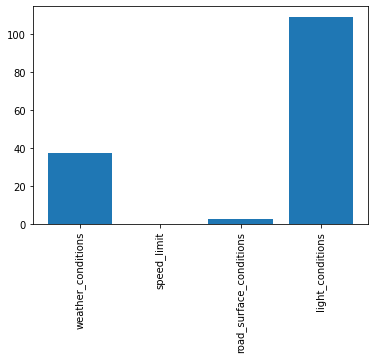

In [126]:
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [137]:
class FeatureSelection:
    def __init__(self):
        pass
        
    def subset_df(self, df, predictors, target):
        return df.filter(predictors + [target])
    
    def filter_for_positive(self, df, predictors, target):
        for i in df.columns:
             df = df.loc[df[i] > 0, :]
        return df
    
    def selection_stat(self, df, predictors, target, dtypes=1):
        """
        Generate the selection statistic
        Input:
            df - input data
            predictors - list of predictors
            target - target feature
            dtypes - data types of inputs and ouputs
                1 - categorical to categorical
                2 - numerical to numerical
                3 - numerical to categorical
        """
        if dtypes == 1:
            return SelectKBest(chi2, k='all')
        elif dtypes == 2:
            return SelectKBest(f_regression, k='all')
        elif dtypes == 3:
            return SelectKBest(f_classif, k='all')
    
    def fit_selector(self, df, selector, predictors, target):
        return selector.fit(df[predictors], df[target])


In [153]:
predictors = ['weather_conditions', 'speed_limit',
              'road_surface_conditions', 'light_conditions',
              'urban_or_rural_area', 'road_type',
              'carriageway_hazards', 'special_conditions_at_site']

target = 'accident_severity'

fs = FeatureSelection()

df = fs.subset_df(accidents, predictors, target)
df = fs.filter_for_positive(df, predictors, target)

selector = fs.selection_stat(df, predictors, target, 1)
fs.fit_selector(df, selector, predictors, target)

scores = -np.log(selector.pvalues_)

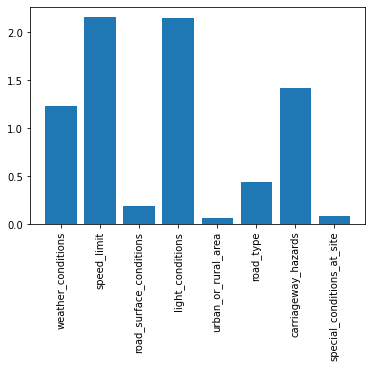

In [154]:
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()